In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, AIMessage, BaseMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

from typing import TypedDict, Annotated

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4.1-mini")

In [4]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_node(state: ChatState):
    
    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision['approved'] == 'no':
        return {"messages": [AIMessage(content="Not Approved.")]}
    
    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}

In [6]:
# Build the graph
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

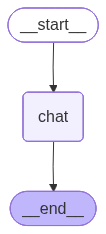

In [7]:
app

In [8]:
# Create a thread ID for this conversation
config = {"configurable": {"thread_id": '1234'}}

# User asks a question
initial_input = {
    "messages": [
        ("user", "Explain Gradient Descent in simple terms")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [9]:
result

{'messages': [HumanMessage(content='Explain Gradient Descent in simple terms', additional_kwargs={}, response_metadata={}, id='5f34eab6-0768-4a5c-8b3e-9d06c917d87a')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain Gradient Descent in simple terms', 'instruction': 'Approve this question? yes/no'}, id='d10f6681ab36c7fb2d66ef7e91fb995a')]}

In [10]:
# Extract the interrupt message
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain Gradient Descent in simple terms',
 'instruction': 'Approve this question? yes/no'}

In [11]:
user_input = input(f"\nBackend Message - {message} \n Approve this question? (yes/no): ")

In [12]:
# Resume the graph with the approval descision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config
)

In [13]:
print(final_result["messages"][-1].content)

Sure! Imagine you're standing on top of a hill, blindfolded, and you want to get down to the lowest point in the valley. Since you can't see, you decide to feel the slope with your feet and take small steps downhill. Each step you take moves you closer to the bottom.

**Gradient Descent** works in a similar way but for finding the lowest point of a function (which often represents an error or cost in machine learning). Here's how it works in simple terms:

1. **Start somewhere:** You pick a starting point on the curve (which could be a random guess).
2. **Check the slope:** Look at the slope (or gradient) at that point—this tells you which direction is uphill or downhill.
3. **Take a step downhill:** Move a little bit in the direction that makes the function value smaller (downhill).
4. **Repeat:** Keep doing this—check the slope, move down a bit—until you can’t go down any further (you find the minimum).

By repeatedly moving in the direction that decreases the error, Gradient Descent